In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations, product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

from src.data_processing import read_netcdfs
from src.plotting import plot_connectivity

import warnings
warnings.filterwarnings('ignore', 'numpy equal will not check object identity in the future')

path = '../Processed-Data/HPa_04_04.nc'

In [4]:
from src.plotting import _plot_distribution

def plot_delay(path, group, brain_area1, brain_area2, frequency_band, figsize=(15, 5)):
    transform_func = lambda ds: ds.sel(
        tetrode1=ds.tetrode1[ds.brain_area1==brain_area1],
        tetrode2=ds.tetrode2[ds.brain_area2==brain_area2],
        frequency_band=frequency_band
    )
    ds = read_netcdfs(
        path, dim='session', group=group,
        transform_func=transform_func).delay

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    DIMS = ['session', 'tetrode1', 'tetrode2']
    
    _plot_distribution(ds, dims=DIMS, ax=axes[0], color='midnightblue')
    axes[0].set_title('Raw delay')
    
    _plot_distribution(ds - ds.isel(time=0), dims=DIMS, ax=axes[1], color='midnightblue')
    axes[1].set_title('Difference from baseline delay')
    
    for ax in axes:
        ax.axvline(0, color='black', linestyle='-')
        ax.axhline(0, color='black', linestyle='-')
    
    plt.tight_layout()
    plt.suptitle(
        '{brain_area1} - {brain_area2}'.format(
            brain_area1=brain_area1, brain_area2=brain_area2),
        fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.85)

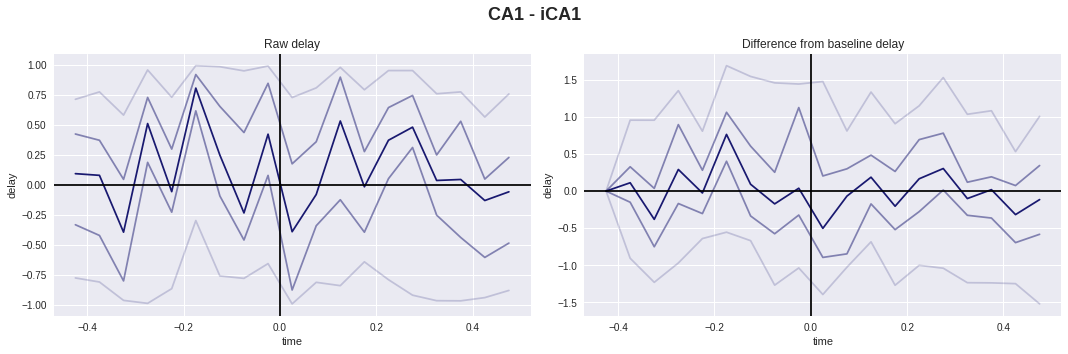

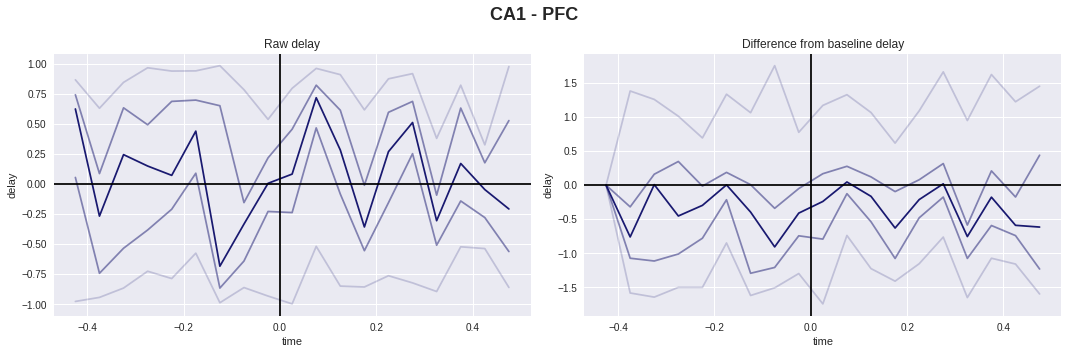

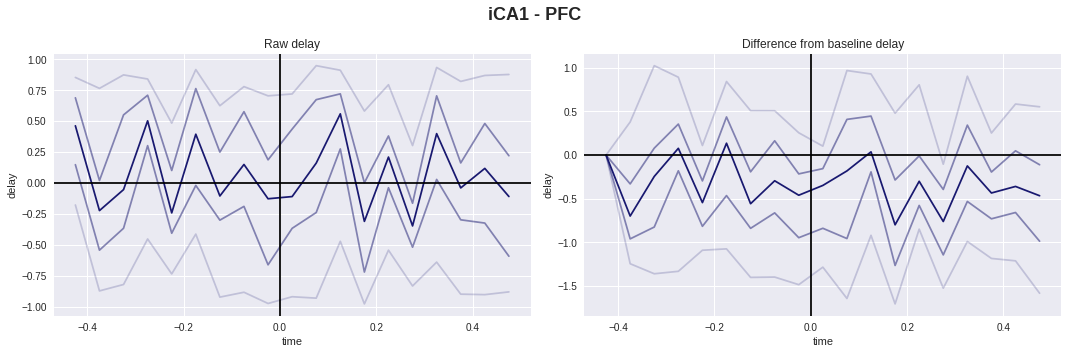

In [4]:
group = '20Hz_Resolution/all_ripples/group_delay'
frequency_band = 'ripple'

brain_areas = ['CA1', 'iCA1', 'PFC']
for brain_area1, brain_area2 in combinations(brain_areas, 2):
    plot_delay(path, group, brain_area1, brain_area2, frequency_band)

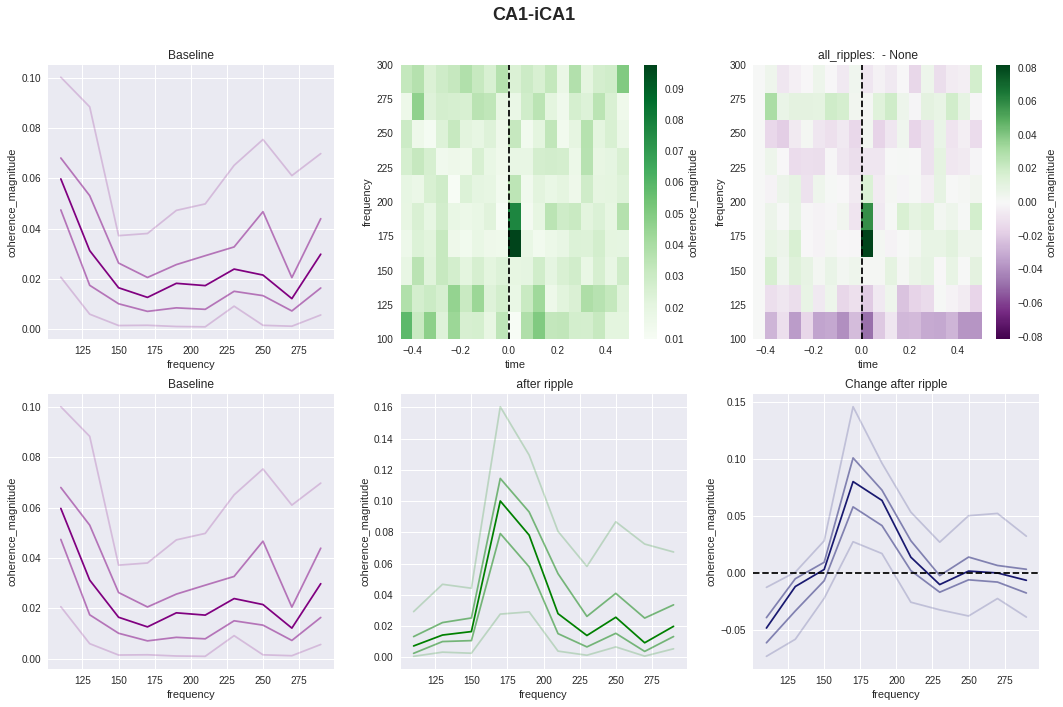

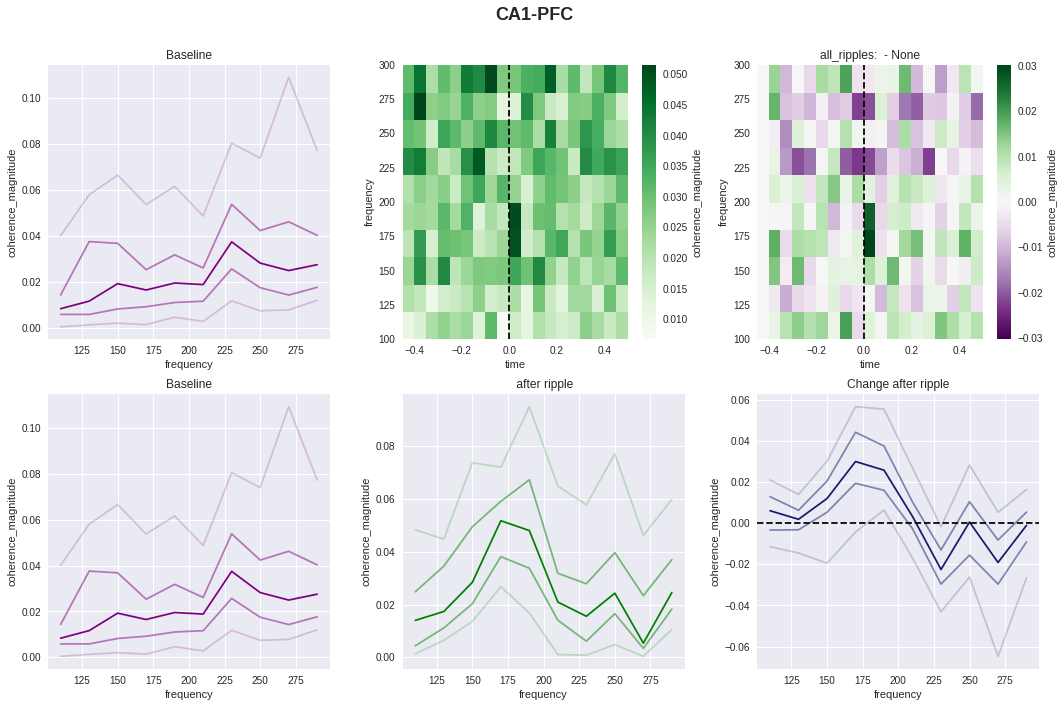

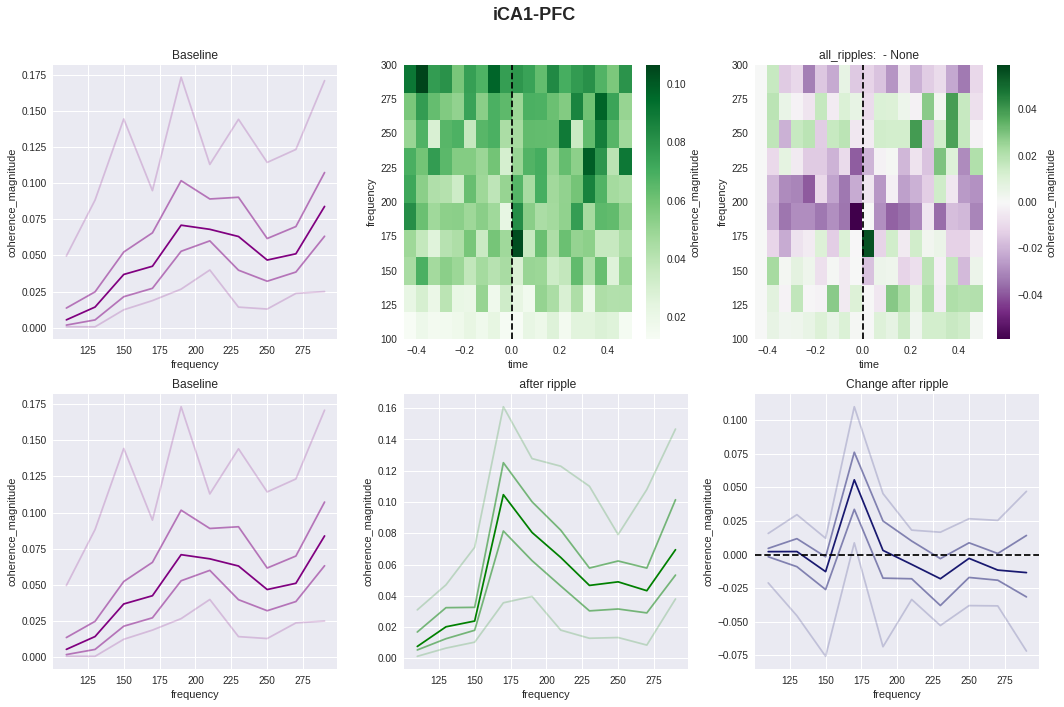

In [5]:
covariate = 'all_ripples'
level1 = ''
level2 = None
frequency = slice(100, 300)
resolution = '20Hz_Resolution'
for brain_area_pair in combinations(brain_areas, 2):
    plot_connectivity(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2, figsize=(15, 10), connectivity_measure='coherence_magnitude')

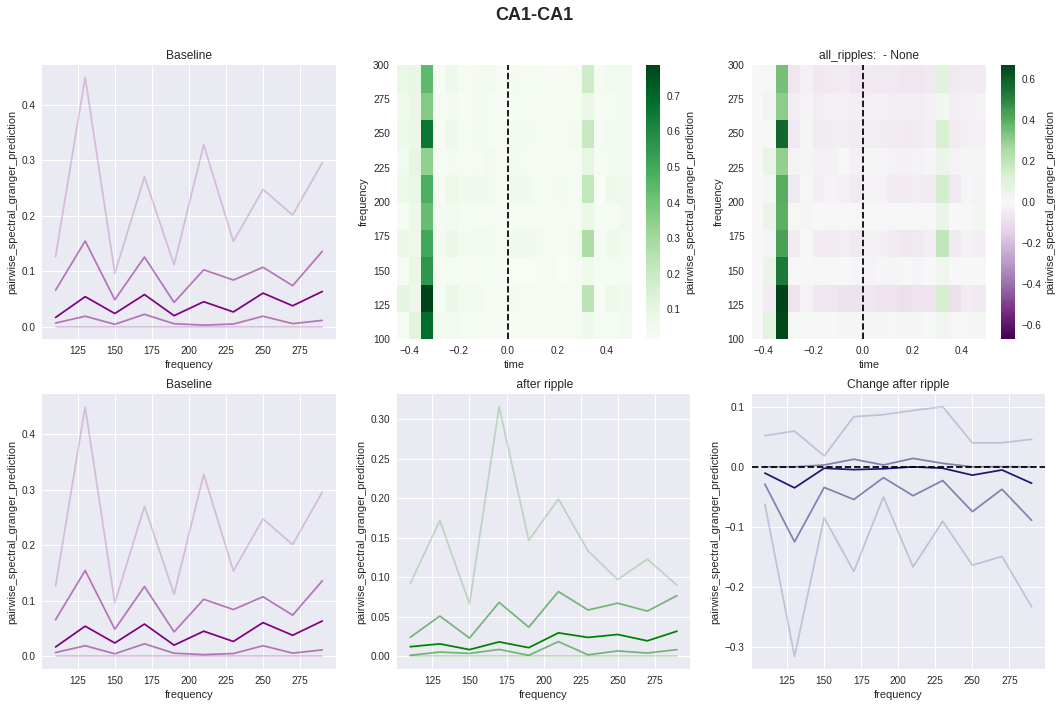

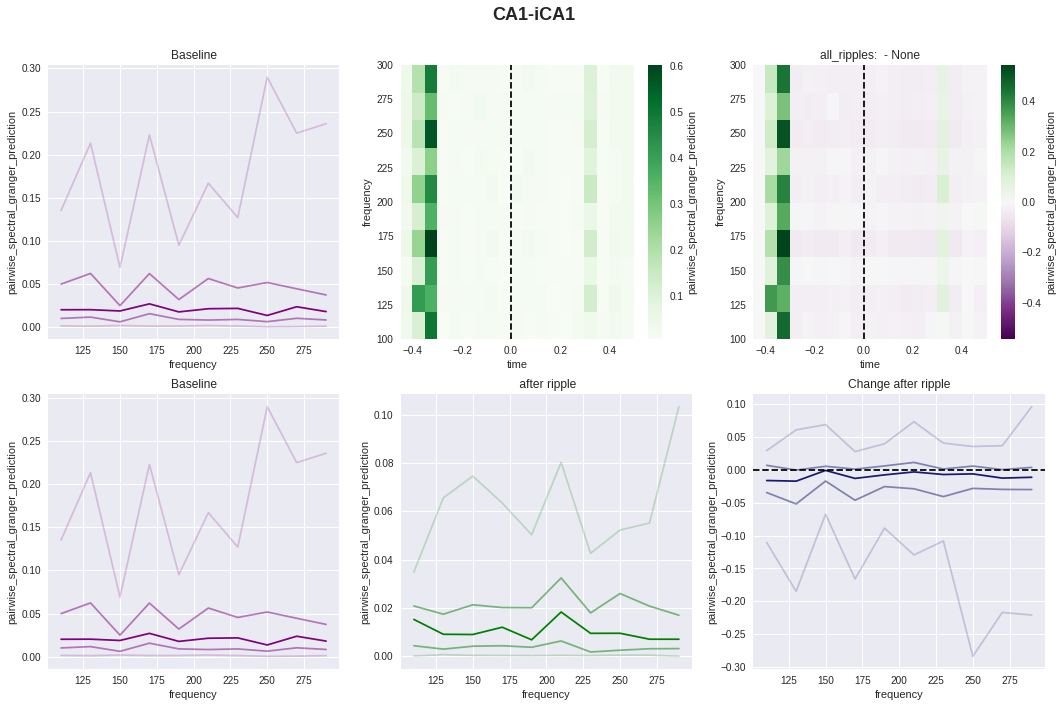

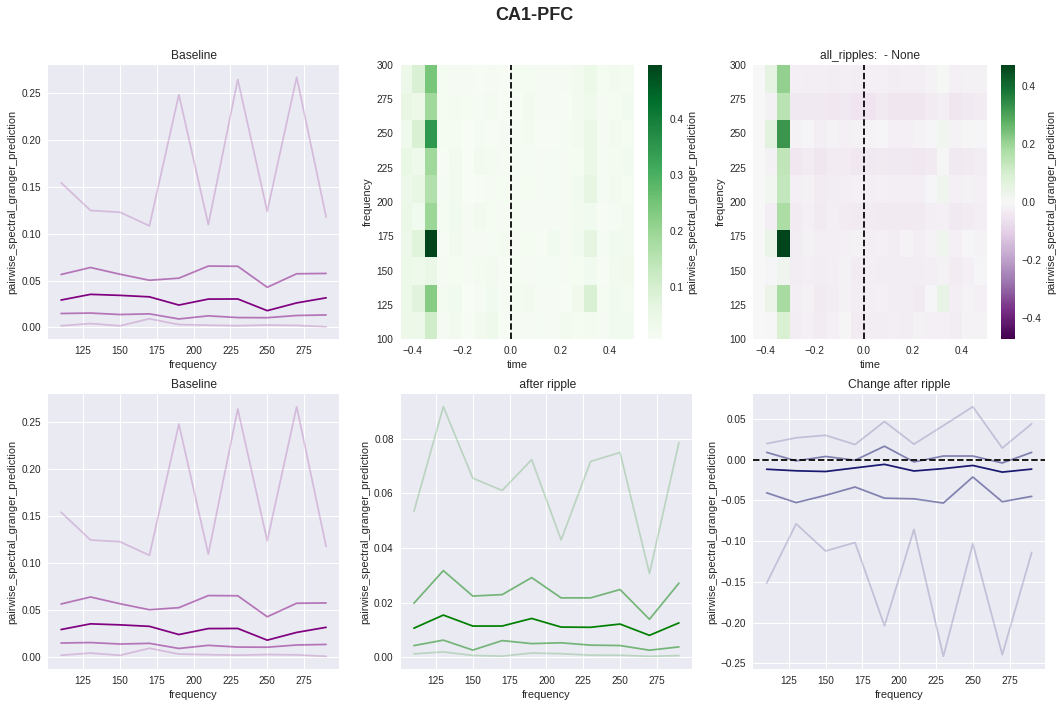

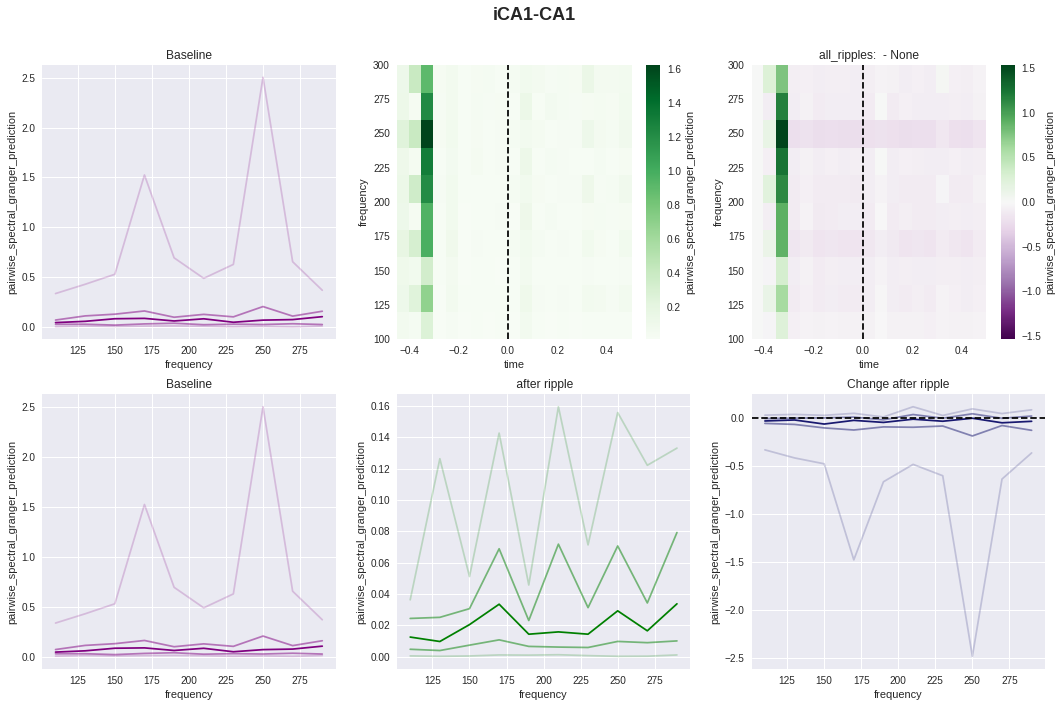

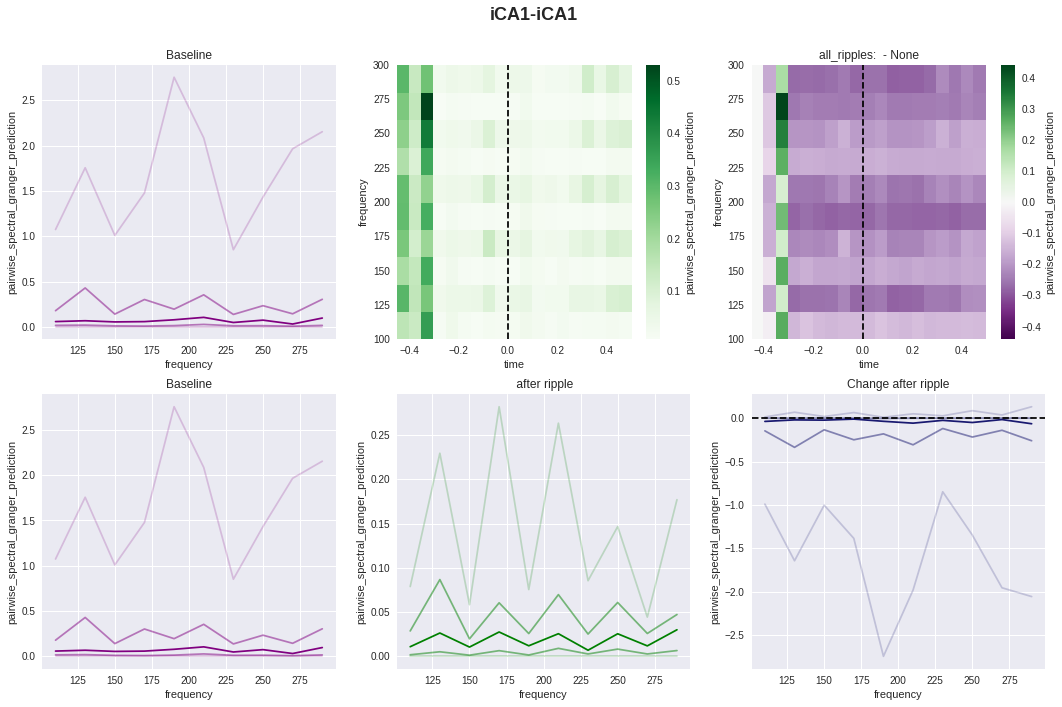

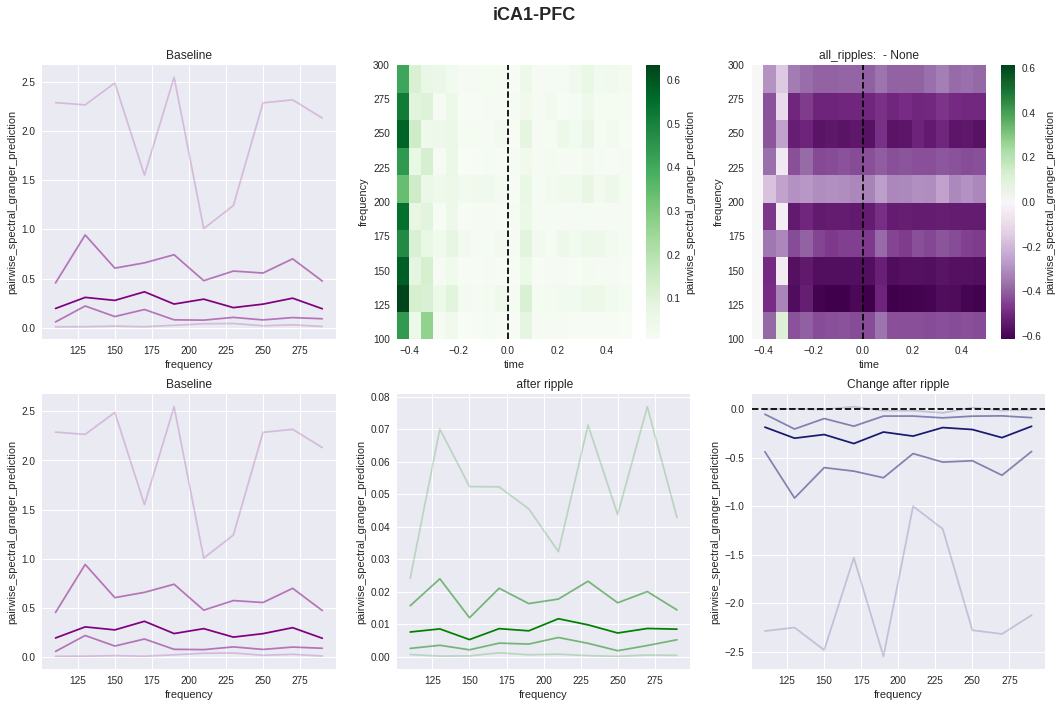

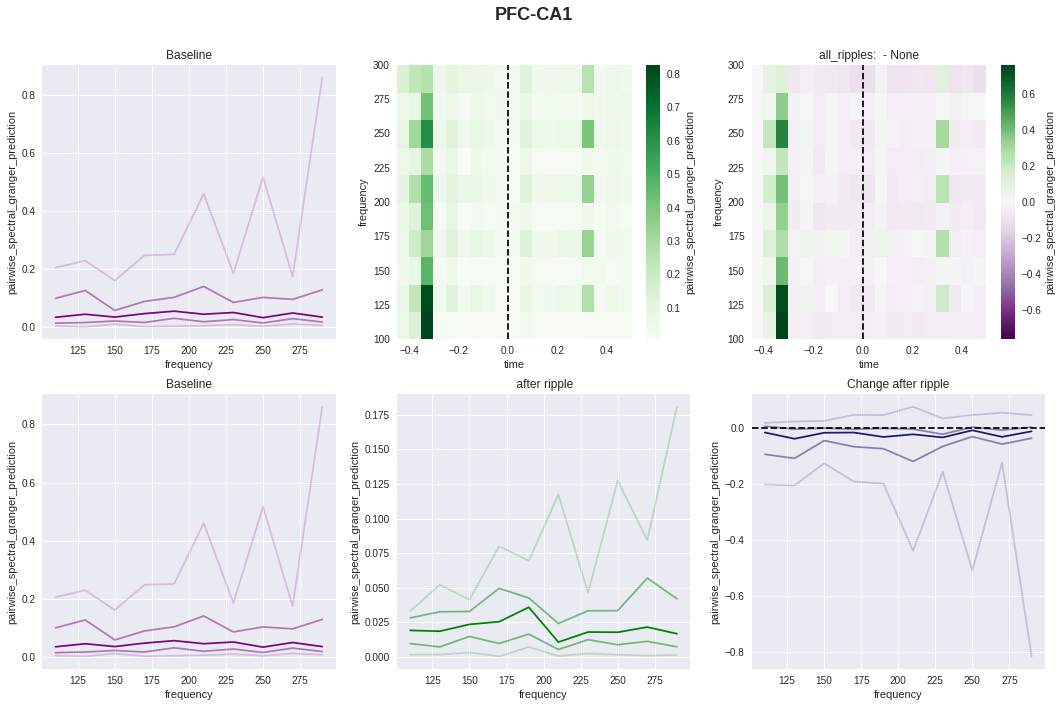

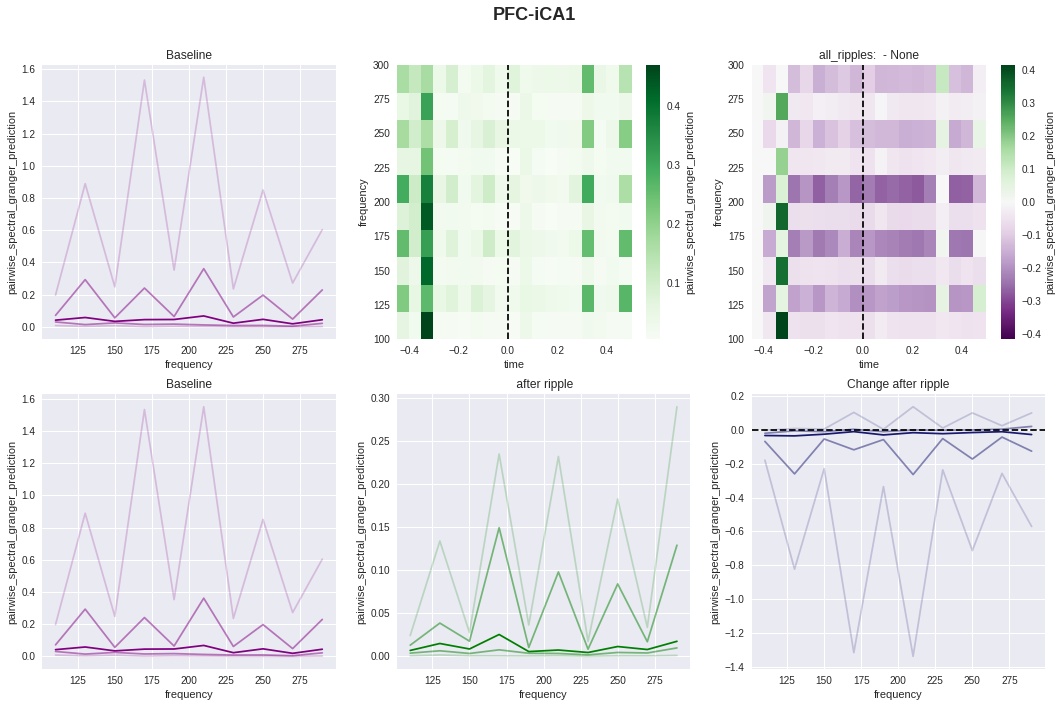

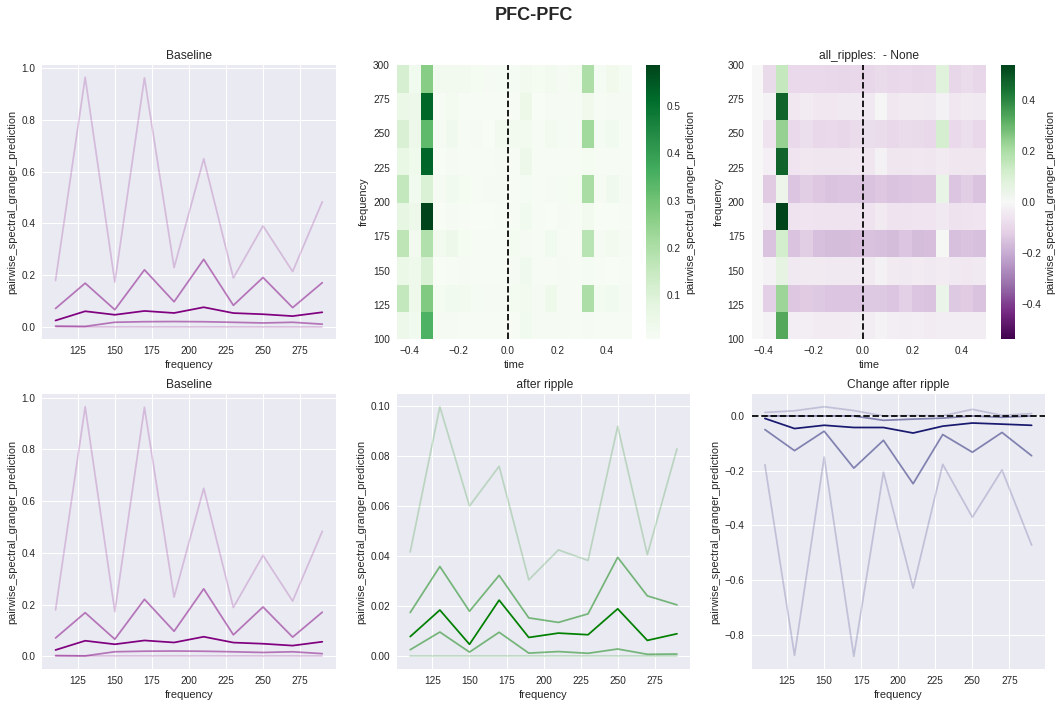

In [9]:
covariate = 'all_ripples'
level1 = ''
level2 = None
frequency = slice(100, 300)
resolution = '20Hz_Resolution'
for brain_area_pair in product(brain_areas, brain_areas):
    plot_connectivity(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2, figsize=(15, 10), connectivity_measure='pairwise_spectral_granger_prediction')

In [3]:
delay = xr.open_dataset(
    path, group='20Hz_Resolution/all_ripples/group_delay').sel(
        frequency_band='ripple').delay

coherence_magnitude = xr.open_dataset(
        path, group='20Hz_Resolution/all_ripples/coherence_magnitude'
    ).sel(frequency=slice(150, 250)).coherence_magnitude

granger_prediction = xr.open_dataset(
        path, group='20Hz_Resolution/all_ripples/pairwise_spectral_granger_prediction'
    ).sel(frequency=slice(150, 250)).pairwise_spectral_granger_prediction

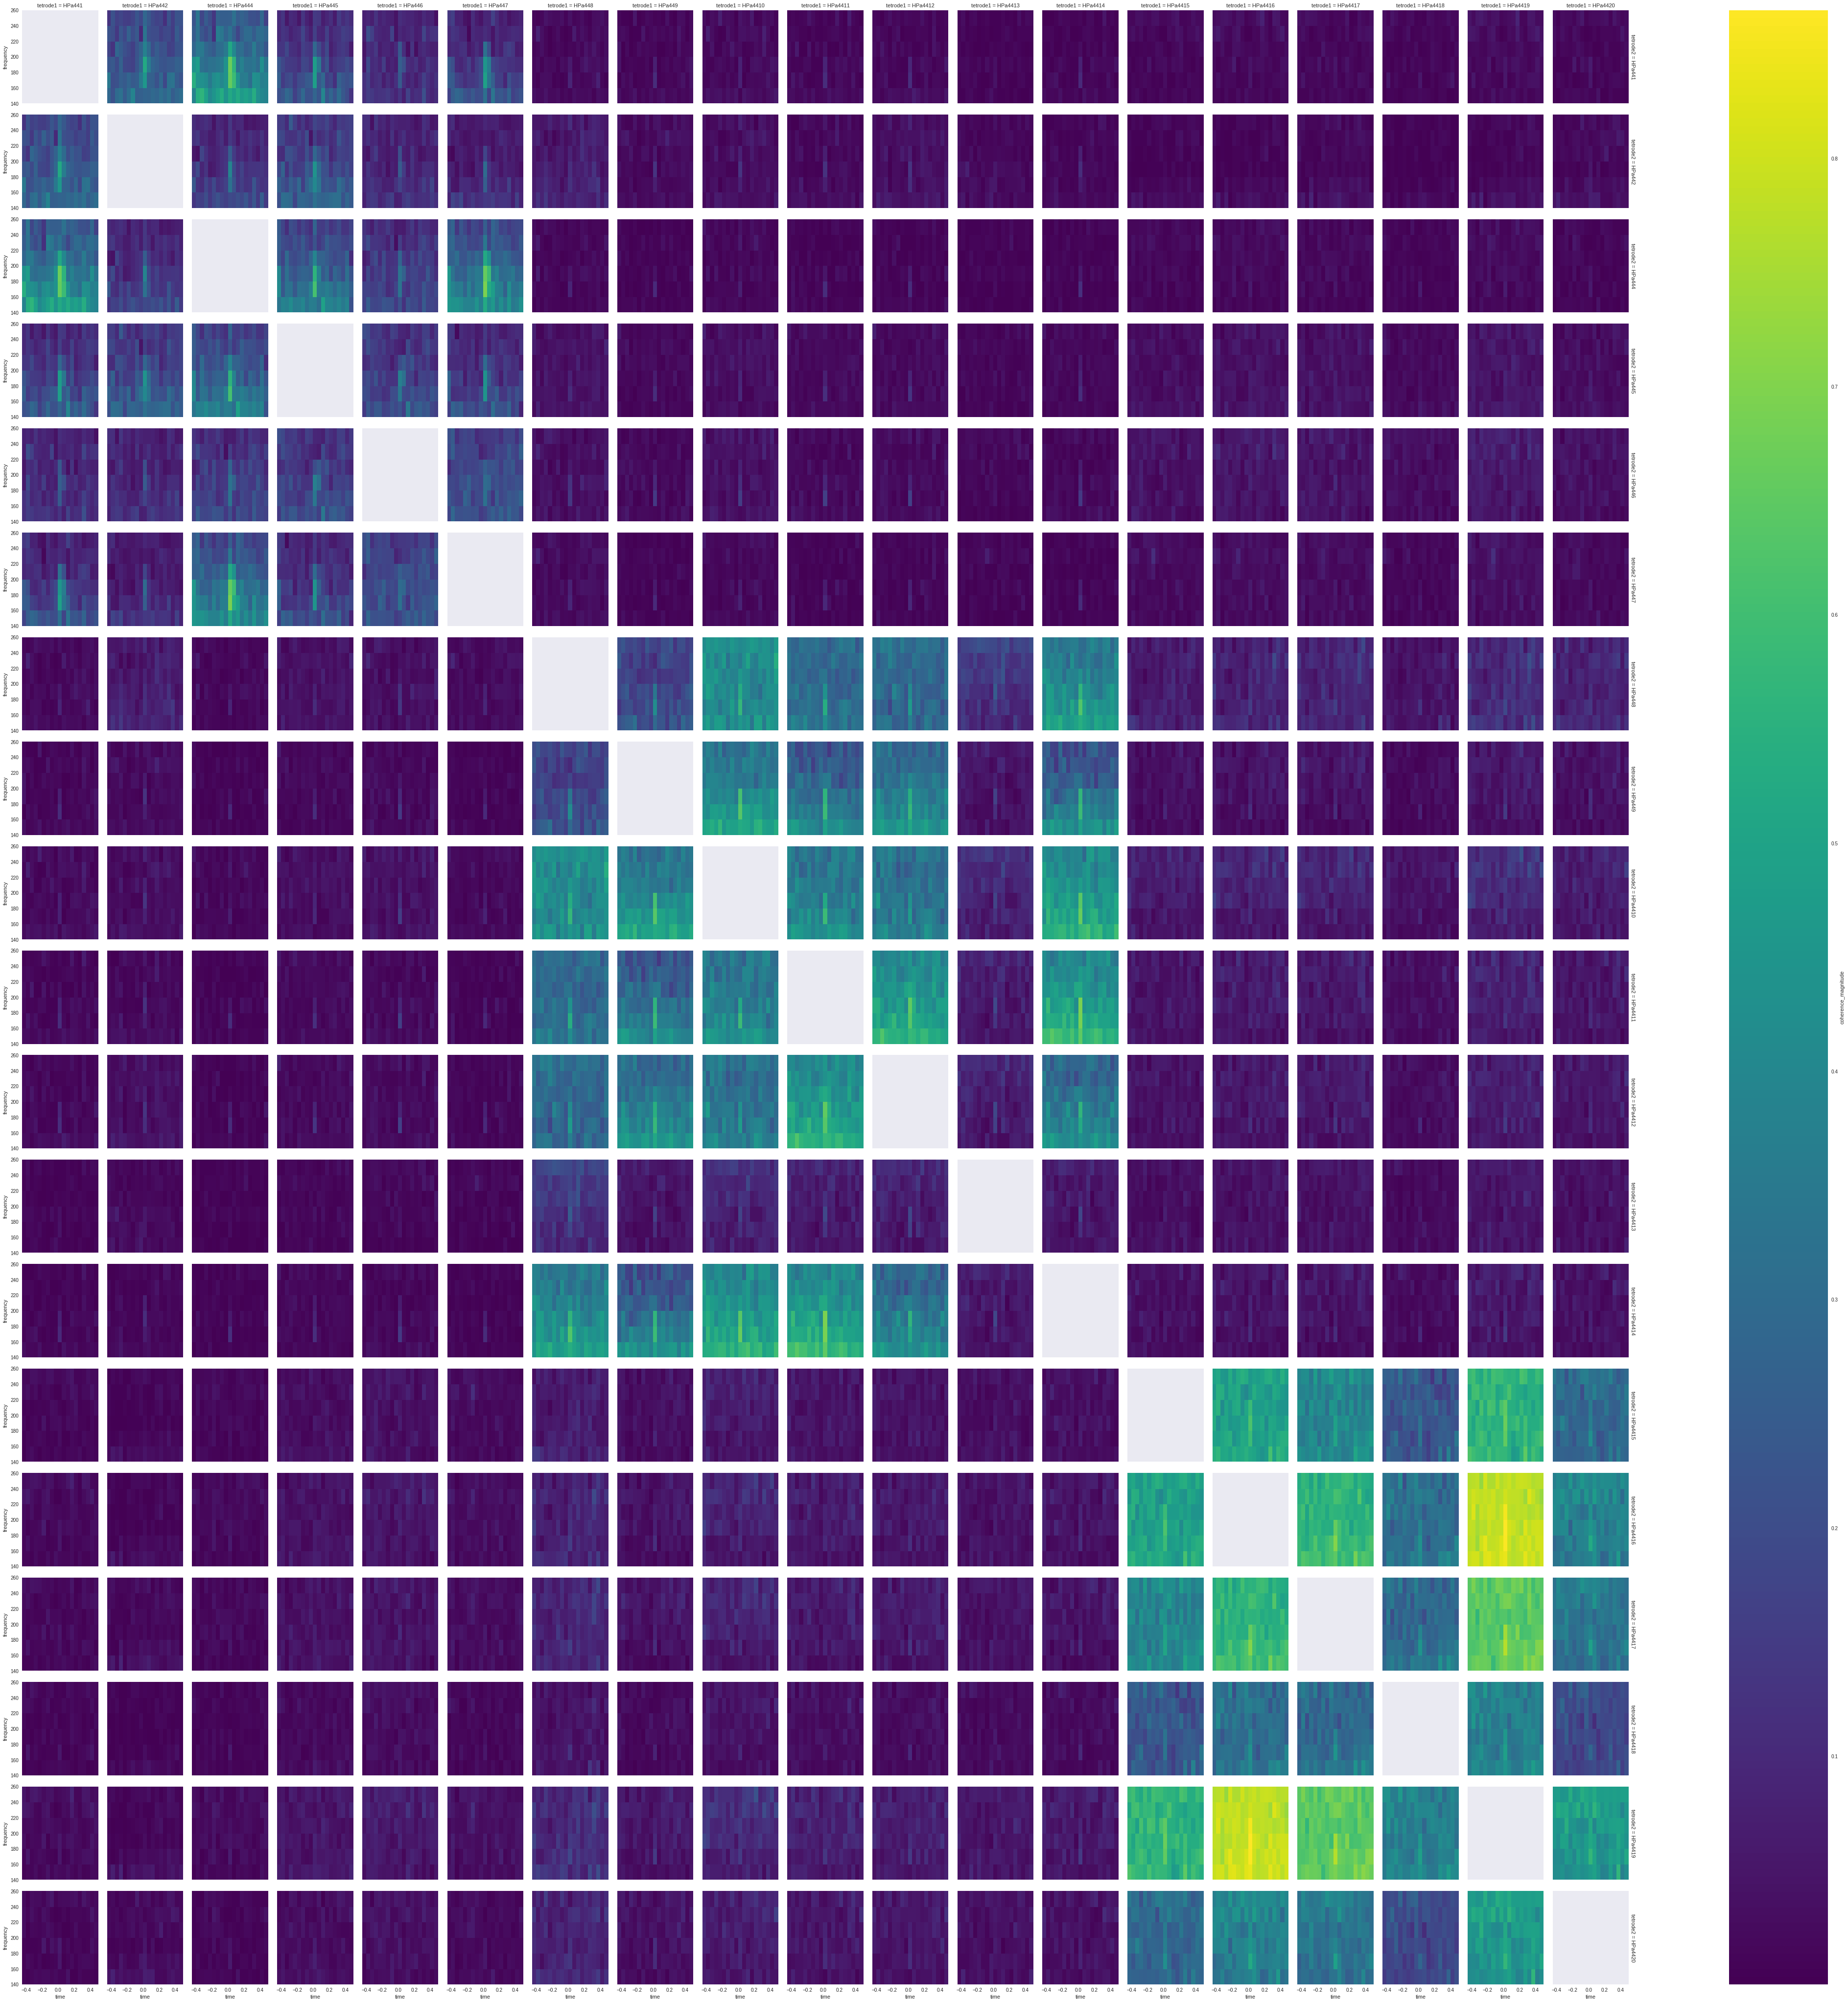

In [22]:
coherence_magnitude.plot(x='time', y='frequency', col='tetrode1', row='tetrode2')

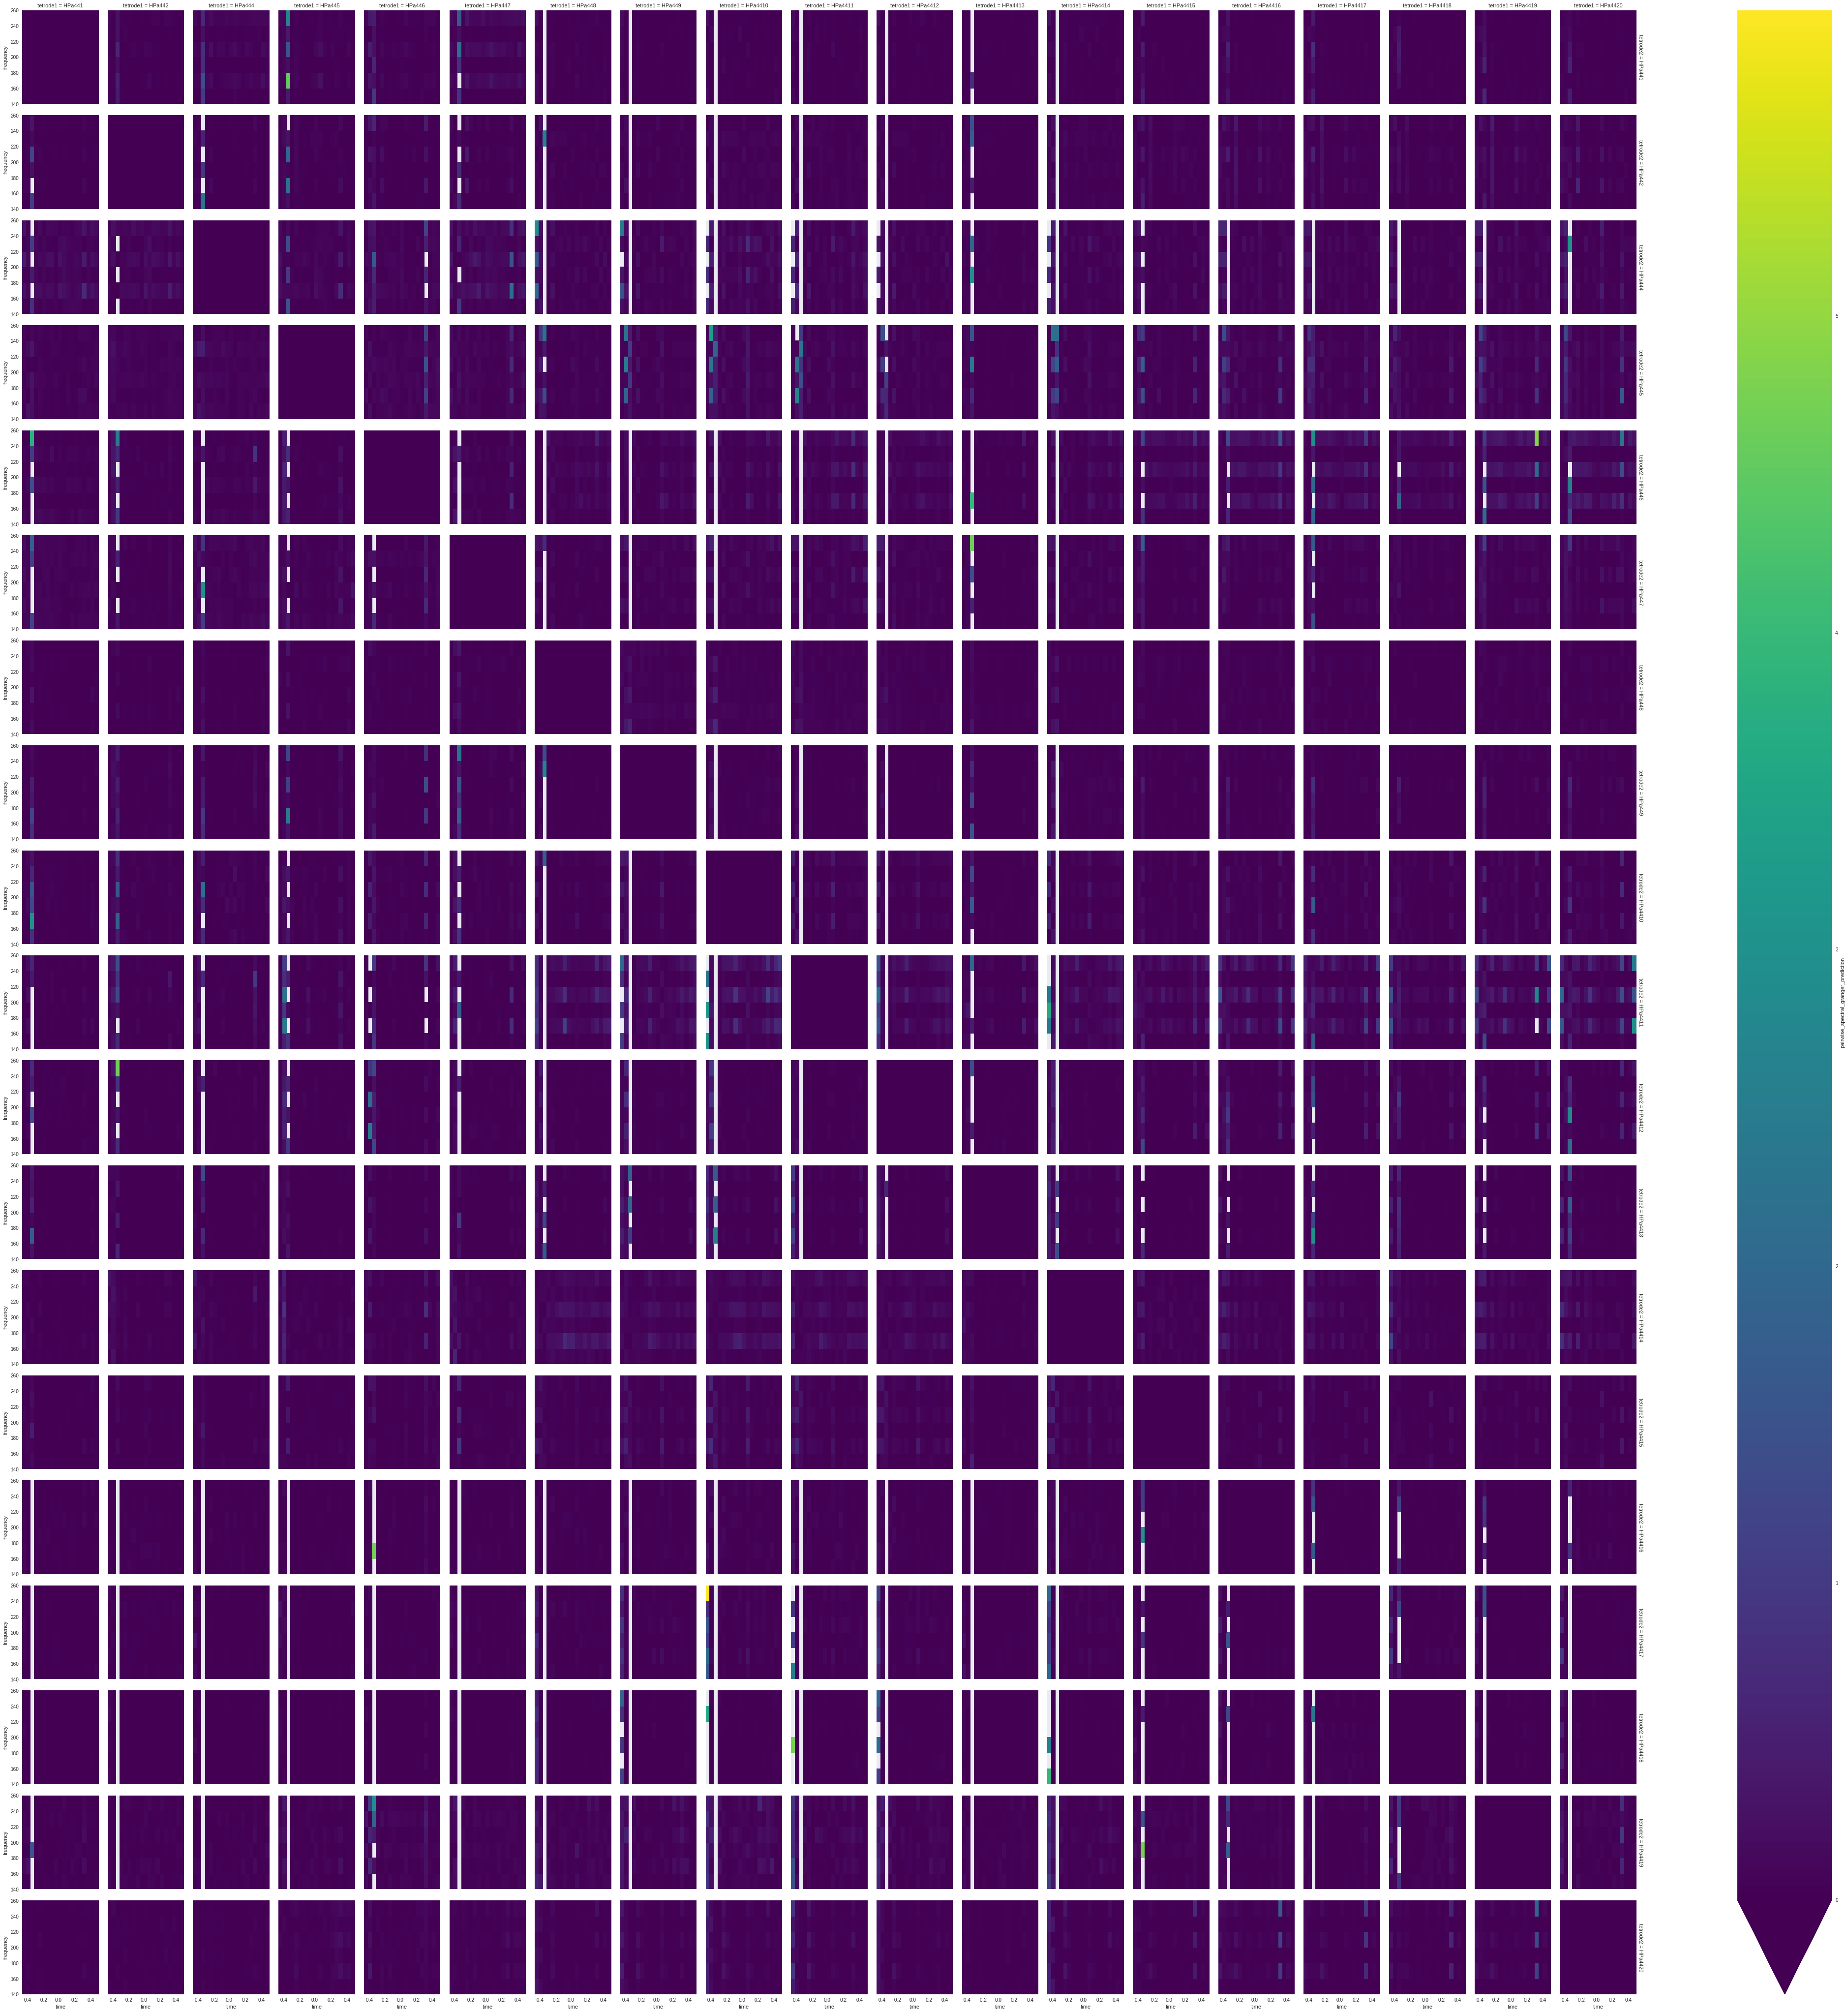

In [28]:
granger_prediction.plot(x='time', y='frequency', col='tetrode1', row='tetrode2', vmin=0)

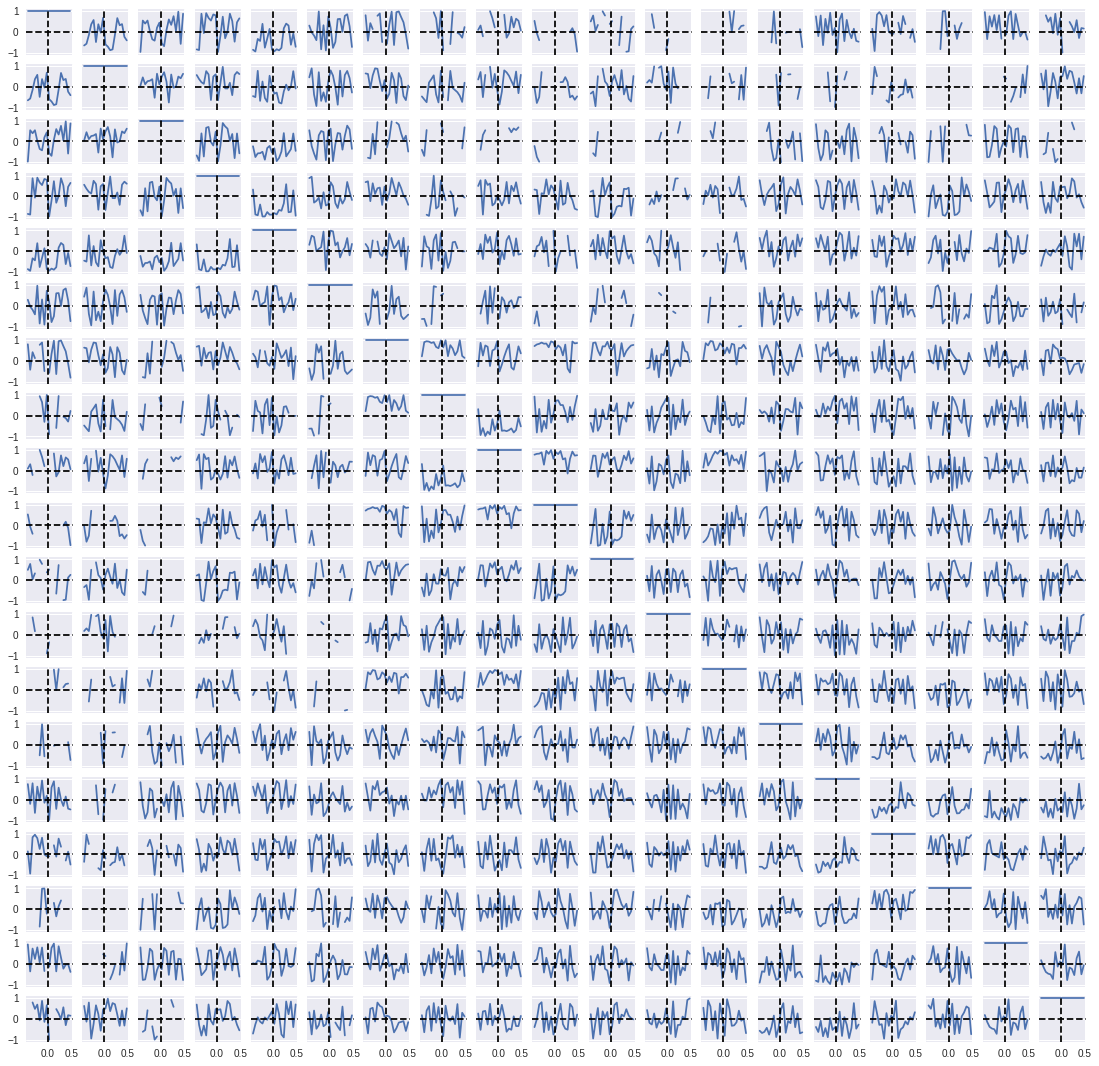

In [41]:
n_tetrodes = len(delay.tetrode1)
fig, ax = plt.subplots(n_tetrodes, n_tetrodes, figsize=(n_tetrodes, n_tetrodes), sharex=True, sharey=True)
for ind1, ind2 in product(range(n_tetrodes), range(n_tetrodes)):
    delay.isel(tetrode1=ind1, tetrode2=ind2).plot(ax=ax[ind1, ind2])
    ax[ind1, ind2].set_title('')
    ax[ind1, ind2].set_xlabel('')
    ax[ind1, ind2].set_ylabel('')
    ax[ind1, ind2].axhline(0, color='black', linestyle='--')
    ax[ind1, ind2].axvline(0, color='black', linestyle='--')

Delay not flipped if reverse the order of the tetrode pairs

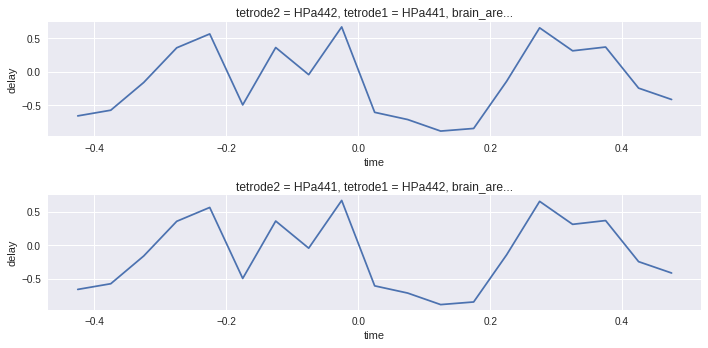

In [12]:
fix, axes = plt.subplots(2, 1, figsize=(10, 5))
delay.isel(tetrode1=0, tetrode2=1).plot(ax=axes[0])
delay.isel(tetrode1=1, tetrode2=0).plot(ax=axes[1])

plt.tight_layout()

Self delay = 1 for some reason

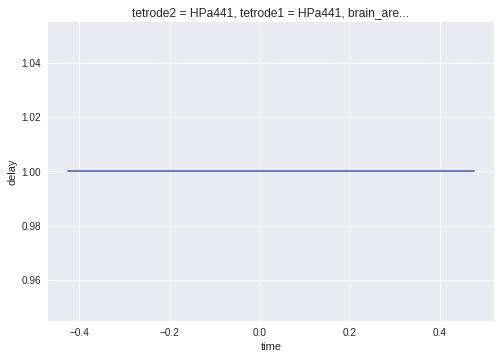

In [13]:
delay.isel(tetrode1=0, tetrode2=0).plot()

In [4]:
blah = xr.open_dataset(
    path, group='20Hz_Resolution/all_ripples/group_delay').sel(
        frequency_band='ripple')

In [5]:
blah

<xarray.Dataset>
Dimensions:         (tetrode1: 19, tetrode2: 19, time: 19)
Coordinates:
  * tetrode2        (tetrode2) object 'HPa441' 'HPa442' 'HPa444' 'HPa445' ...
  * tetrode1        (tetrode1) object 'HPa441' 'HPa442' 'HPa444' 'HPa445' ...
    brain_area1     (tetrode1) object 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' ...
    brain_area2     (tetrode2) object 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' ...
    frequency_band  <U6 'ripple'
  * time            (time) float64 -0.425 -0.375 -0.325 -0.275 -0.225 -0.175 ...
Data variables:
    r_value         (time, tetrode1, tetrode2) float64 1.0 -0.6583 -0.9697 ...
    delay           (time, tetrode1, tetrode2) float64 1.0 -0.6583 -0.9697 ...
    slope           (time, tetrode1, tetrode2) float64 1.0 -0.6583 -0.9697 ...

In [6]:
epoch_key = ('HPa', 4, 4)

In [7]:
from src.analysis import (decode_ripple_clusterless,
                          detect_epoch_ripples,
                          ripple_triggered_connectivity,
                          connectivity_by_ripple_type)
from src.data_processing import (get_LFP_dataframe, make_tetrode_dataframe,
                                 save_ripple_info)
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
tetrode_info = tetrode_info[
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]

lfps = {tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_info.index}

parameters_name = '20Hz_Resolution'
parameters = MULTITAPER_PARAMETERS[parameters_name]

/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
from copy import deepcopy
from functools import partial, wraps
from logging import getLogger

import numpy as np
import pandas as pd
import xarray as xr
from dask import local, compute, delayed

from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)
from src.ripple_decoding import (combined_likelihood,
                              estimate_marked_encoding_model,
                              estimate_sorted_spike_encoding_model,
                              estimate_state_transition, get_bin_centers,
                              predict_state, set_initial_conditions)
from src.ripple_detection import Kay_method
from src.spectral.connectivity import Connectivity
from src.spectral.transforms import Multitaper

from src.analysis import _subtract_event_related_potential

n_lfps = len(lfps)
n_pairs = int(n_lfps * (n_lfps - 1) / 2)

params = deepcopy(parameters)
window_of_interest = params.pop('window_of_interest')
reshape_to_trials = partial(
    reshape_to_segments,
    sampling_frequency=params['sampling_frequency'],
    window_offset=window_of_interest, concat_axis=1)

ripple_locked_lfps = pd.Panel({
    lfp_name: _subtract_event_related_potential(
        reshape_to_trials(lfps[lfp_name], ripple_times))
    for lfp_name in lfps}).dropna(axis=2)
m = Multitaper(
    np.rollaxis(ripple_locked_lfps.values, 0, 3),
    **params,
    start_time=ripple_locked_lfps.major_axis.min())
c = Connectivity.from_multitaper(m)

In [11]:
n_bands = len(FREQUENCY_BANDS)
delay, slope, r_value = (
    np.zeros((c.time.size, n_bands, m.n_signals, m.n_signals)),) * 3


In [17]:
d, s, r = c.group_delay(
            FREQUENCY_BANDS['ripple'],
            frequency_resolution=m.frequency_resolution)

In [23]:
d[0, :2, :2]

array([[ 0.        , -0.00019447],
       [ 0.00019447,  0.        ]])

In [24]:
for band_ind, frequency_band in enumerate(FREQUENCY_BANDS):
    (delay[:, band_ind, ...],
     slope[:, band_ind, ...],
     r_value[:, band_ind, ...]) = c.group_delay(
        FREQUENCY_BANDS[frequency_band],
        frequency_resolution=m.frequency_resolution)

In [25]:
delay[0, -1, :2, :2]

array([[  1.,  nan],
       [ nan,   1.]])

In [26]:
r_value[0, -1, :2, :2]

array([[  1.,  nan],
       [ nan,   1.]])

In [42]:
blah = np.array([c.group_delay(
            FREQUENCY_BANDS[frequency_band], frequency_resolution=m.frequency_resolution)
        for frequency_band in FREQUENCY_BANDS])

blah.shape

(6, 3, 19, 19, 19)

In [45]:
blah[1, 0, 0, :2, :2]

array([[ 0.        , -0.00019447],
       [ 0.00019447,  0.        ]])

In [48]:
from src.analysis import _center_time

group_delay = np.array(
    [c.group_delay(FREQUENCY_BANDS[frequency_band],
                   frequency_resolution=m.frequency_resolution)
     for frequency_band in FREQUENCY_BANDS])

dimension_names = ['frequency_band', 'time', 'tetrode1', 'tetrode2']
data_vars = {
    'delay': (dimension_names, group_delay[:, 0, ...]),
    'slope': (dimension_names, group_delay[:, 1, ...]),
    'r_value': (dimension_names, group_delay[:, 2, ...])}
coordinates = {
    'time': _center_time(c.time),
    'frequency_band': list(FREQUENCY_BANDS.keys()),
    'tetrode1': tetrode_info.tetrode_id.values,
    'tetrode2': tetrode_info.tetrode_id.values,
    'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
    'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
    }

In [49]:
xr.Dataset(data_vars, coords=coordinates)

<xarray.Dataset>
Dimensions:         (frequency_band: 6, tetrode1: 19, tetrode2: 19, time: 19)
Coordinates:
  * tetrode2        (tetrode2) object 'HPa441' 'HPa442' 'HPa444' 'HPa445' ...
  * time            (time) float64 -0.425 -0.375 -0.325 -0.275 -0.225 -0.175 ...
  * tetrode1        (tetrode1) object 'HPa441' 'HPa442' 'HPa444' 'HPa445' ...
    brain_area1     (tetrode1) <U4 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' ...
  * frequency_band  (frequency_band) <U10 'slow_gamma' 'ripple' 'fast_gamma' ...
    brain_area2     (tetrode2) <U4 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' ...
Data variables:
    delay           (frequency_band, time, tetrode1, tetrode2) float64 0.0 ...
    r_value         (frequency_band, time, tetrode1, tetrode2) float64 1.0 ...
    slope           (frequency_band, time, tetrode1, tetrode2) float64 0.0 ...

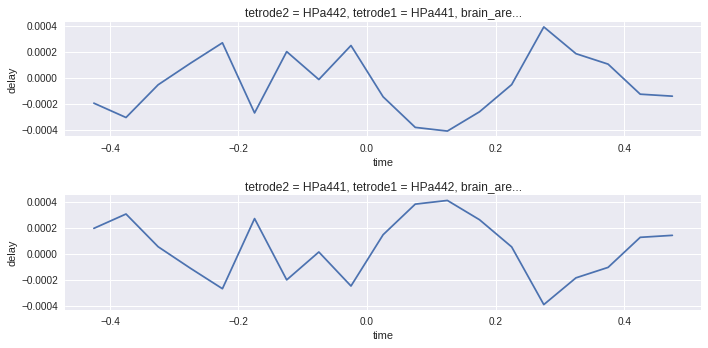

In [51]:
d = xr.Dataset(data_vars, coords=coordinates).delay.sel(frequency_band='ripple')
fix, axes = plt.subplots(2, 1, figsize=(10, 5))
d.isel(tetrode1=0, tetrode2=1).plot(ax=axes[0])
d.isel(tetrode1=1, tetrode2=0).plot(ax=axes[1])

plt.tight_layout()

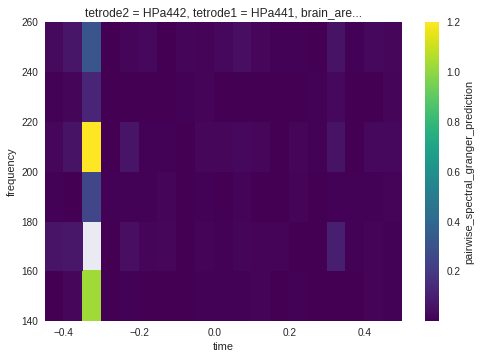

In [4]:
granger_prediction.isel(tetrode1=0, tetrode2=1).plot(x='time', y='frequency')

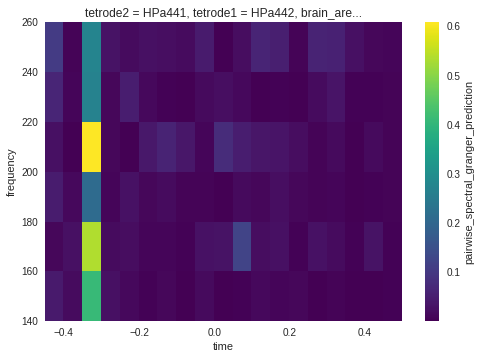

In [5]:
granger_prediction.isel(tetrode1=1, tetrode2=0).plot(x='time', y='frequency')

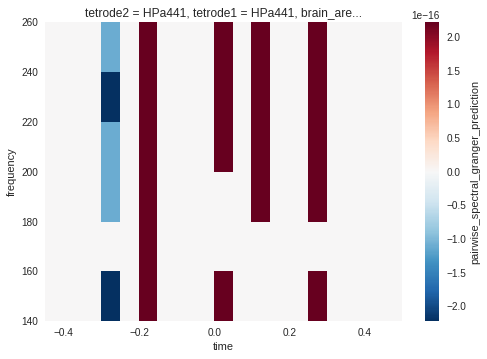

In [6]:
granger_prediction.isel(tetrode1=0, tetrode2=0).plot(x='time', y='frequency')